## Data Import and Initial Exploration

### Overview
In this step, we import the Ames housing dataset and perform an initial inspection to understand its structure. This includes loading the training and test data, previewing the first few rows, reviewing summary statistics for the target variable (`SalePrice`), and identifying variables with the highest number of missing values.

### Code Purpose
- Load the training and test CSV files using Pandas  
- Display dataset dimensions  
- Preview the first rows of the training dataset  
- Summarize the distribution of `SalePrice`  
- Identify columns with the most missing values to guide data cleaning

### Output Analysis
The training dataset contains **1,460 observations and 81 features**, while the test dataset includes **1,459 observations and 80 features**, confirming that `SalePrice` is only present in the training set since it is the target variable to predict.

A preview of the first rows shows a mix of numeric and categorical variables describing property characteristics such as lot size, zoning, building style, and construction details. The summary statistics for `SalePrice` indicate:

- **Mean** price of approximately \$180,921  
- **Median** price of \$163,000, slightly below the mean (suggesting right skew)  
- **Minimum** price of \$34,900 and **maximum** of \$755,000  

This confirms a wide range of housing values in Ames, Iowa, and hints at a skewed distribution, which is common in real estate data.

The missing value summary reveals that some columns have substantial missing data, especially:

- `PoolQC`, `MiscFeature`, `Alley`, `Fence`
- Several basement and garage-related fields

Most of these missing values relate to optional home features rather than errors. This insight will guide our cleaning strategy, such as assigning “None” where a feature does not exist or imputing values where appropriate in later steps.


In [1]:
import pandas as pd
import numpy as np

train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

print("train shape:", train.shape)
print("test shape:", test.shape)

display(train.head(5))

display(train["SalePrice"].describe(percentiles=[0.25,0.5,0.75]).to_frame().T)

display(train.isnull().sum().sort_values(ascending=False).head(20).to_frame("n_missing"))


train shape: (1460, 81)
test shape: (1459, 80)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


,count,mean,std,min,25%,50%,75%,max
SalePrice,1460.0,180921.19589,79442.502883,34900.0,129975.0,163000.0,214000.0,755000.0


,n_missing
PoolQC,1453
MiscFeature,1406
Alley,1369
Fence,1179
MasVnrType,872
FireplaceQu,690
LotFrontage,259
GarageQual,81
GarageFinish,81
GarageType,81


##  Distribution of SalePrice and Log-Transformed SalePrice

### Overview
This step examines the distribution of the target variable, `SalePrice`, and applies a logarithmic transformation to assess whether it improves normality. Understanding the distribution of the target variable is important for selecting appropriate modeling techniques and evaluation metrics.

### Code Purpose
- Plot the raw distribution of home sale prices
- Plot the distribution after applying a natural log transformation
- Compute skewness before and after log transformation to quantify improvement

### Output Analysis
The left histogram shows that **SalePrice is right-skewed**, with most properties priced between 100,000 to 300,000, and a long tail of high-value homes reaching above \$700,000. This skewness is confirmed numerically, with a **skew value of ~1.88**, indicating substantial deviation from normality.

The log-transformed distribution on the right appears much more symmetric and bell-shaped. The skewness after transformation decreases dramatically to **~0.12**, indicating that the log transformation results in a distribution close to normal.

This transformation is beneficial because:

- Many machine learning algorithms perform better when the target variable is approximately normally distributed
- It stabilizes variance, making errors more balanced across price ranges
- The Kaggle competition evaluation metric (RMSE on log prices) aligns with this approach

As a result, we will model `LogSalePrice` rather than raw `SalePrice` in later analysis steps.


Skew (raw): 1.8828757597682129
Skew (log): 0.12133506220520406


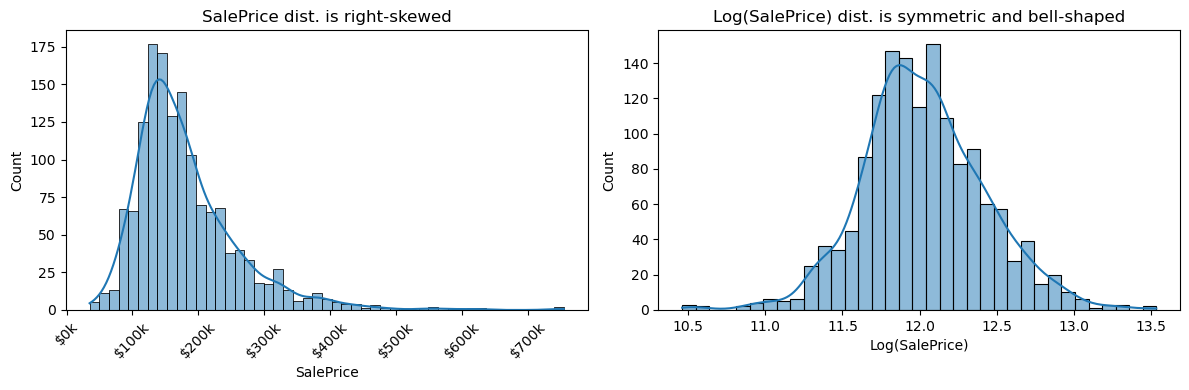

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick

fig, axes = plt.subplots(1, 2, figsize=(12,4))

sns.histplot(train["SalePrice"], kde=True, ax=axes[0])
axes[0].set_title("SalePrice dist. is right-skewed")
axes[0].tick_params(axis='x', rotation=45)
axes[0].xaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f"${x/1000:.0f}k"))

log_prices = np.log(train["SalePrice"])
sns.histplot(log_prices, kde=True, ax=axes[1])
axes[1].set_title("Log(SalePrice) dist. is symmetric and bell-shaped")
axes[1].set_xlabel("Log(SalePrice)")

plt.tight_layout()

print("Skew (raw):", train["SalePrice"].skew())
print("Skew (log):", log_prices.skew())



##  Data Cleaning and Log Transformation

### Overview
This step prepares the dataset for modeling by handling missing values and creating a log-transformed version of the target variable (`SalePrice`). Proper data cleaning ensures that machine learning algorithms can run without errors and that numerical inputs are meaningful.

### Code Purpose
- Create a working copy of the training dataset  
- Identify numeric and categorical columns  
- Impute missing values:
  - Numeric columns → filled with the median  
  - Categorical columns → filled with the string `"None"` to indicate absence of a feature  
- Add a new column containing the log-transformed sale price (`LogSalePrice`)  
- Verify that all missing values have been addressed  

### Output Analysis
All missing values were successfully handled, as indicated by:

"Remaining missing values: 0"

This confirms that the dataset is now complete and ready for downstream modeling steps. Replacing numeric missing values with the median preserves distribution characteristics without being heavily influenced by outliers, while assigning `"None"` to categorical features appropriately captures cases where a property lacks amenities such as a fence, alley access, or masonry veneer.

The preview of columns `SalePrice` and `LogSalePrice` shows that the log transformation has been applied correctly. We will use `LogSalePrice` as the target variable in our prediction models to account for the previously observed skew in home prices and to align with standard evaluation metrics for this dataset.


In [3]:
train_clean = train.copy()

numeric_vars = train_clean.select_dtypes(include=[np.number]).columns
categorical_vars = train_clean.select_dtypes(include=["object"]).columns

for col in numeric_vars:
    train_clean[col] = train_clean[col].fillna(train_clean[col].median())

for col in categorical_vars:
    train_clean[col] = train_clean[col].fillna("None")

train_clean["LogSalePrice"] = np.log(train_clean["SalePrice"])

print("Remaining missing values:", train_clean.isnull().sum().sum())
train_clean[["SalePrice","LogSalePrice"]].head()


Remaining missing values: 0


,SalePrice,LogSalePrice
0,208500,12.247694
1,181500,12.109011
2,223500,12.317167
3,140000,11.849398
4,250000,12.429216


## Correlation Analysis of Numerical Features

### Overview
To understand which housing attributes most strongly influence price, we analyzed correlations between numerical features and `SalePrice`. This helps prioritize features and informs model design.

### Code Purpose
- Compute correlations between all numeric variables and `SalePrice`
- Identify and rank the top 15 most correlated predictors
- Visualize correlations both with `SalePrice` and among top predictors using heatmaps and bar charts

### Output Analysis
The strongest price predictors include **OverallQual (~0.79)**, **GrLivArea (~0.71)**, and garage and foundation size features (≈0.61-0.64), confirming that quality and square footage are key value drivers. `LogSalePrice` remains highly aligned with `SalePrice`, validating the transformation.

The heatmap demonstrates expected clustering, such as living-area features correlating with each other and garage size metrics moving together. These patterns indicate meaningful structure in the dataset and point to potential multicollinearity, which later modeling steps can handle through regularization or feature selection.



SalePrice       1.000000
LogSalePrice    0.948374
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
YearRemodAdd    0.507101
MasVnrArea      0.472614
Fireplaces      0.466929
GarageYrBlt     0.466754
Name: SalePrice, dtype: float64


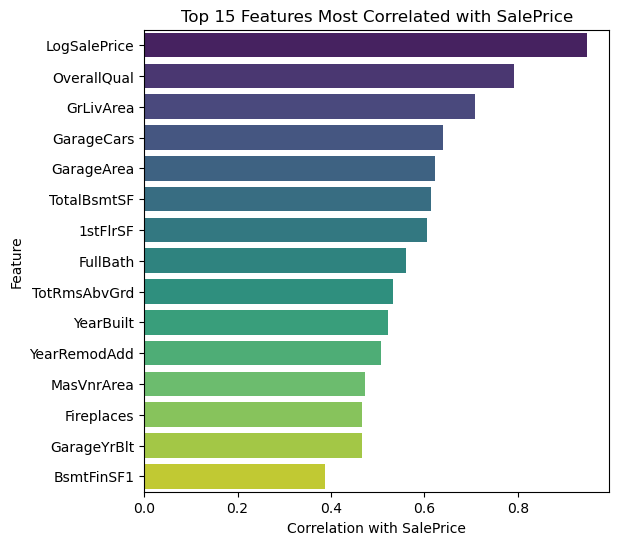

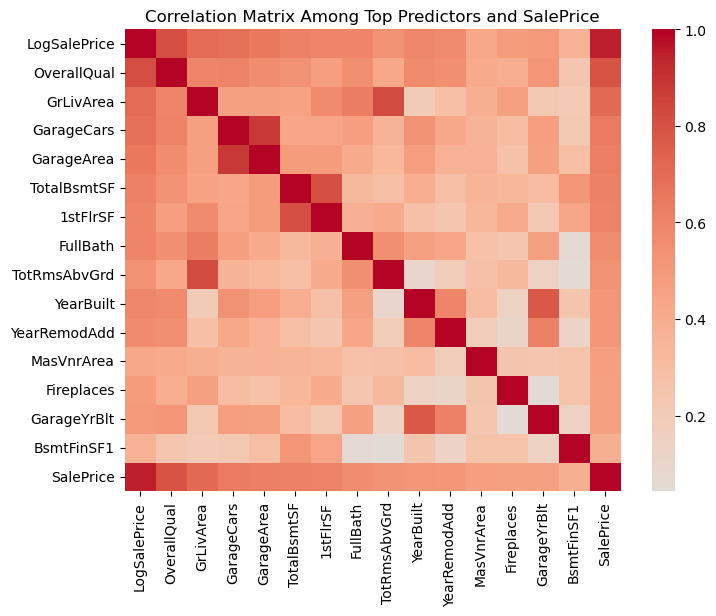

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

corr_values = train_clean.corr(numeric_only=True)["SalePrice"].sort_values(ascending=False).head(15)
print(corr_values)

top_corr = (
    train_clean.corr(numeric_only=True)["SalePrice"]
    .drop("SalePrice")
    .sort_values(ascending=False)
    .head(15)
)

plt.figure(figsize=(6,6))
sns.barplot(
    x=top_corr.values,
    y=top_corr.index,
    hue=top_corr.index,
    palette="viridis",
    legend=False
)
plt.title("Top 15 Features Most Correlated with SalePrice")
plt.xlabel("Correlation with SalePrice")
plt.ylabel("Feature")
plt.show()

top_features = top_corr.index.tolist() + ["SalePrice"]

plt.figure(figsize=(8,6))
sns.heatmap(
    train_clean[top_features].corr(numeric_only=True),
    annot=False,
    cmap="coolwarm",
    center=0
)
plt.title("Correlation Matrix Among Top Predictors and SalePrice")
plt.show()



##  Relationship Between Key Predictors and Sale Price

### Overview
This step visualizes the relationship between home sale prices and two influential features: above-ground living area (`GrLivArea`) and neighborhood. These plots help confirm trends observed in the correlation analysis and illustrate how physical size and location drive housing values.

### Code Purpose
- Create a scatterplot of `GrLivArea` vs. `SalePrice` to visualize the effect of square footage on home prices  
- Create a boxplot of `SalePrice` grouped by the top 10 neighborhoods ranked by median price  
- Highlight distribution differences and potential outliers in both relationships

### Output Analysis
The scatterplot on the left shows a strong positive relationship between **above-ground living area** and **sale price**. Larger homes tend to sell for higher prices, and the upward trend is consistent with real estate expectations. A few extreme outliers are present, particularly very large homes that do not command proportionally higher prices, which may indicate unusual properties or special sale circumstances.

The boxplot on the right illustrates how **neighborhood significantly influences housing values**. Higher-priced neighborhoods exhibit higher medians and wider price distributions, whereas more modest neighborhoods show lower and more compact price ranges. This confirms that **location is a major determinant of property value**, and incorporating neighborhood information is essential for accurate predictions.

Together, these visualizations support our modeling strategy by identifying size and neighborhood as key predictors and showcasing variation in real estate pricing within Ames.


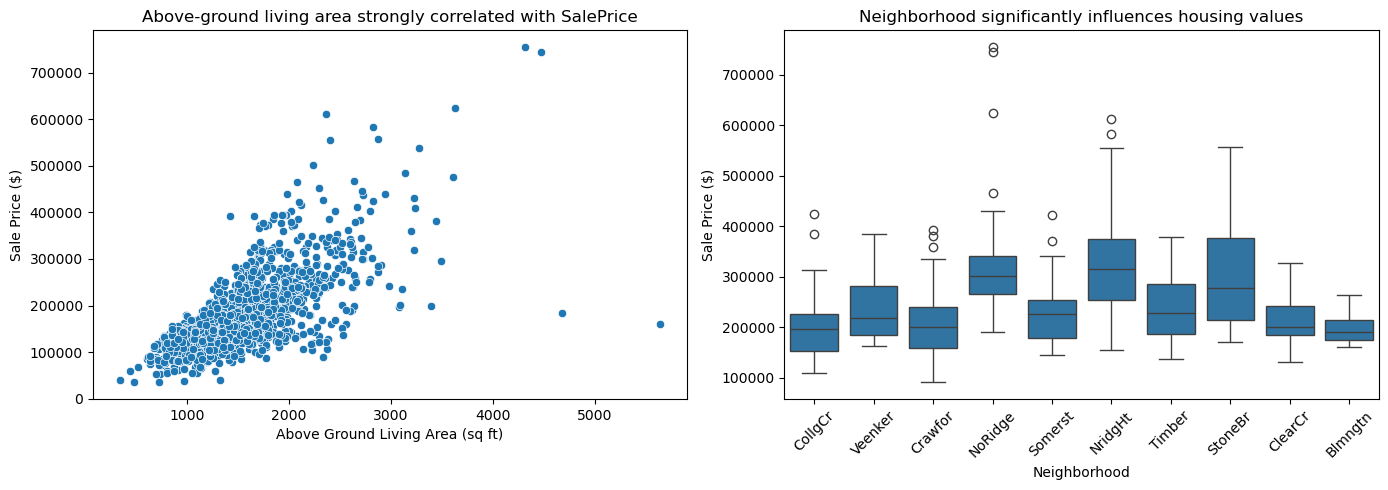

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(14,5))

sns.scatterplot(x=train_clean["GrLivArea"], y=train_clean["SalePrice"], ax=axes[0])
axes[0].set_title("Above-ground living area strongly correlated with SalePrice")
axes[0].set_xlabel("Above Ground Living Area (sq ft)")
axes[0].set_ylabel("Sale Price ($)")

top_neighborhoods = train_clean.groupby("Neighborhood")["SalePrice"].median().sort_values().tail(10).index

sns.boxplot(
    x="Neighborhood",
    y="SalePrice",
    data=train_clean[train_clean["Neighborhood"].isin(top_neighborhoods)],
    ax=axes[1]
)
axes[1].set_title("Neighborhood significantly influences housing values")
axes[1].set_xlabel("Neighborhood")
axes[1].set_ylabel("Sale Price ($)")
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


##  Feature Encoding and Train-Validation Split

### Overview
Before training our predictive model, we prepare the dataset by converting categorical variables into numerical format and splitting the data into training and validation sets. These steps ensure the model can learn effectively and that we can objectively evaluate its performance.

### Code Purpose
- Create feature matrix `X` and target variable `y`, using the log-transformed sale price (`LogSalePrice`)
- Convert categorical variables into numeric dummy variables using one-hot encoding
  - `drop_first=True` avoids multicollinearity by removing one category from each encoded feature
- Split the data into training (80 percent) and validation (20 percent) subsets
  - Ensures that model performance can be evaluated on unseen data

### Output Analysis
The resulting shapes:

X_train: 1168 rows × 261 features
X_val: 292 rows × 261 features


confirm that the data has been successfully processed for modeling. After one-hot encoding, the dataset now includes **261 numerical predictors**, reflecting the original numeric features plus encoded categorical variables. The consistent feature count across training and validation sets ensures compatibility during model training and evaluation.

This step establishes the foundation for building machine-learning models by providing a clean, numerical feature matrix and a properly defined target variable.


In [6]:
from sklearn.model_selection import train_test_split

train_model = train_clean.copy()

X = train_model.drop(["SalePrice","LogSalePrice"], axis=1)
y = train_model["LogSalePrice"]

X = pd.get_dummies(X, drop_first=True)

X_train, X_val, y_train, y_val = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42
)

X_train.shape, X_val.shape


((1168, 261), (292, 261))

##  Baseline Linear Regression Model and RMSE Evaluation

### Overview
In this step, we train a baseline linear regression model to predict the log-transformed sale price of homes and evaluate its performance using Root Mean Squared Error (RMSE). This serves as our initial benchmark before exploring more advanced modeling techniques.

### Code Purpose
- Initialize and fit a **LinearRegression** model using the training data
- Generate predictions on the validation set
- Calculate the RMSE between predicted and actual log sale prices
  - RMSE measures the average prediction error in log-price units and is consistent with the evaluation metric for this dataset

### Output Analysis
The model produced an RMSE of: 0.1733

This value represents the average error between predicted and actual log-scaled home prices. Given that this is a simple baseline model without feature engineering or regularization, a performance of approximately **0.17 RMSE** is reasonable for the Ames housing dataset.  

This result indicates that the model captures general pricing patterns but leaves room for improvement. In later steps, we can apply other predictive modeling techniques to better capture non-linear relationships and reduce overfitting.



In [7]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

model_lr = LinearRegression()
model_lr.fit(X_train, y_train)

y_pred = model_lr.predict(X_val)

rmse_lr = np.sqrt(mean_squared_error(y_val, y_pred))
print("Linear Regression RMSE:", rmse_lr)


Linear Regression RMSE: 0.1733018578714101


##  Residual Analysis for Linear Regression Model

### Overview
After fitting the baseline linear regression model, we visualize the model's residuals (prediction errors) to evaluate how well the model captures the underlying structure in the data. Residual analysis helps assess model fit and diagnose issues such as non-linearity or heteroscedasticity.

### Code Purpose
- Compute residuals (actual − predicted log sale prices)
- Create a scatterplot of residuals versus predicted values
- Display summary statistics of residuals to quantify their behavior

### Output Analysis
The residual plot shows that most points are tightly clustered around the horizontal zero line, indicating that the model’s predictions are generally accurate without systematic bias. The mean residual is approximately 0.003, very close to zero, further confirming that predictions are unbiased on average.

The spread of residuals appears fairly consistent across predicted values, suggesting **no strong evidence of heteroscedasticity** in this baseline model. This indicates that the model performs similarly across different price levels. A few noticeable outliers remain, including one large positive residual, which likely represents an atypical property or an unusual sale event not captured well by a linear model.

The summary statistics show:

- Standard deviation of residuals ≈ 0.174, consistent with the RMSE  
- A small number of larger residuals (max ≈ 1.97), indicating rare cases where the model significantly underestimates price

Overall, the linear model performs reasonably well for most homes in the dataset, though the presence of outliers suggests there may be nonlinear patterns or interactions that a basic linear model cannot fully capture. Future steps using regularized or non-linear models may reduce error further and better handle unusual properties.



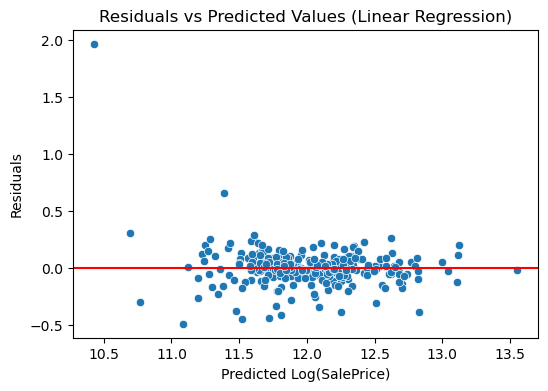

count    292.000000
mean       0.003256
std        0.173569
min       -0.487005
25%       -0.059910
50%        0.004874
75%        0.063133
max        1.965926
Name: LogSalePrice, dtype: float64

In [8]:
residuals = y_val - y_pred

plt.figure(figsize=(6,4))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(0, color="red")
plt.xlabel("Predicted Log(SalePrice)")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted Values (Linear Regression)")
plt.show()

residuals.describe()


## Additional Models: Lasso Regression, Random Forest Regression, kNN, and Stacked Ensemble

In this section, we extend our baseline model by exploring three additional approaches: Lasso Regression, Random Forest Regression, and k-Nearest Neighbors (kNN). These models allow us to address multicollinearity, capture nonlinear relationships, and compare performance across conceptually different modeling strategies. We also introduce a stacked ensemble model that combines Lasso and Random Forest (kNN proved uncompetitive) to learn an optimal blend of linear and nonlinear components for improved accuracy.


### Lasso Regression


In [9]:
from sklearn.linear_model import LassoCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

alphas = np.logspace(-4, 0, 30)

lasso_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("lasso", LassoCV(alphas=alphas, cv=5, max_iter=20000, random_state=42))
])

lasso_pipeline.fit(X_train, y_train)

best_alpha = lasso_pipeline.named_steps["lasso"].alpha_
print(f"Best alpha (L1 penalty strength) selected by CV: {best_alpha:.5f}")

y_pred_lasso = lasso_pipeline.predict(X_val)
rmse_lasso = np.sqrt(mean_squared_error(y_val, y_pred_lasso))
print(f"Lasso Regression RMSE: {rmse_lasso}")

lasso_coefs = pd.Series(
    lasso_pipeline.named_steps["lasso"].coef_,
    index=X_train.columns
)

nonzero_coefs = lasso_coefs[lasso_coefs != 0]

top_predictors = nonzero_coefs.abs().sort_values(ascending=False).head(20)

top_predictors

Best alpha (L1 penalty strength) selected by CV: 0.01172
Lasso Regression RMSE: 0.15192452846353435


GrLivArea               0.114288
OverallQual             0.109505
GarageCars              0.050174
YearBuilt               0.037487
OverallCond             0.027226
YearRemodAdd            0.023767
MSZoning_RM             0.022201
BsmtFullBath            0.021820
PoolQC_Gd               0.021084
TotalBsmtSF             0.018193
CentralAir_Y            0.017790
Condition2_PosN         0.015060
FireplaceQu_None        0.012677
Neighborhood_NridgHt    0.012044
Foundation_PConc        0.011699
MSSubClass              0.011232
Neighborhood_Crawfor    0.011052
Fireplaces              0.011051
LotArea                 0.010842
GarageType_Attchd       0.009565
dtype: float64

Lasso Regression extends our baseline linear model by adding an L1 penalty that shrinks less important coefficients toward zero and can remove predictors entirely. This helps address the high correlation between many Ames features and creates a more stable, interpretable model.

Using LassoCV, we allowed cross-validation to automatically choose the best penalty strength. Our Lasso model achieved a validation RMSE of **0.1519**, which improves upon the baseline linear regression RMSE of approximately **0.173**. This indicates that regularization helps capture the underlying structure of the data more effectively than an unpenalized model.

The key predictors identified by Lasso closely align with the strongest correlations observed earlier, confirming that features such as GrLivArea, OverallQual, and garage-related attributes are consistently influential in explaining home prices.

Overall, Lasso highlights which predictors are most influential by zeroing out weaker coefficients. This contributes to our analysis by:

1. Handling multicollinearity through coefficient shrinkage.  
2. Performing feature selection, making the model easier to interpret.  
3. Providing a stronger linear benchmark for comparison with nonlinear models like Random Forest and kNN.


### Random Forest Regression

In [10]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd

depth_values = [5, 10, 15, 20, 30, None]
best_rmse = float("inf")
best_depth = None

for d in depth_values:
    rf_model = RandomForestRegressor(
        n_estimators=1000,
        max_depth=d,
        min_samples_split=2,
        min_samples_leaf=1,
        max_features="sqrt",
        random_state=42,
        n_jobs=-1
    )
    
    rf_model.fit(X_train, y_train)
    preds = rf_model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, preds))
    
    if rmse < best_rmse:
        best_rmse = rmse
        best_depth = d
        best_model = rf_model

print("Best max_depth:", best_depth)
print("Best RMSE:", best_rmse)

best_importances = pd.Series(
    best_model.feature_importances_,
    index=X_train.columns
).sort_values(ascending=False)

best_importances.head(15)




Best max_depth: 20
Best RMSE: 0.16208002615336686


OverallQual       0.077375
GrLivArea         0.073513
YearBuilt         0.048641
TotalBsmtSF       0.043182
GarageArea        0.042872
GarageCars        0.041074
1stFlrSF          0.039121
ExterQual_TA      0.032475
GarageYrBlt       0.032213
YearRemodAdd      0.029138
FullBath          0.028651
LotArea           0.024087
Fireplaces        0.022219
BsmtFinSF1        0.020835
KitchenQual_TA    0.020744
dtype: float64

Random Forest Regression introduces a nonlinear, tree-based approach that can capture interactions and complex patterns missed by linear models. Unlike Lasso, which uses coefficient shrinkage to stabilize a linear relationship, Random Forests average many decision trees to reduce variance and improve predictive robustness.

The model achieved a validation RMSE of **0.1621**, outperforming the baseline linear regression model but not the Lasso model (≈0.1519). This suggests that although nonlinear structure exists in the Ames dataset, the regularized linear model still captures the dominant signal more effectively, likely due to the large number of sparse one-hot encoded features.

Feature importance rankings highlight OverallQual, GrLivArea, YearBuilt, TotalBsmtSF, and GarageArea as the strongest predictors, aligning with both the correlation analysis and the Lasso results. This consistency reinforces that home quality, size, and structural characteristics are the primary drivers of sale price.

Random Forest contributes to the broader analysis by:

- Capturing nonlinear relationships and interactions  
- Providing stable feature importance measures  
- Offering a meaningful nonlinear benchmark alongside the linear models  

Although it does not surpass Lasso’s performance, it confirms the robustness of key predictors and adds depth to our understanding of the dataset’s structure.


### k-Nearest Neighbors

In [11]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

knn_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("knn", KNeighborsRegressor(n_neighbors=5))
])

knn_pipeline.fit(X_train, y_train)

y_pred_knn = knn_pipeline.predict(X_val)

rmse_knn = np.sqrt(mean_squared_error(y_val, y_pred_knn))
print("KNN RMSE:", rmse_knn)

pd.DataFrame({
    "Actual": y_val.values,
    "Predicted": y_pred_knn
}).head()

KNN RMSE: 0.21823365806612235


,Actual,Predicted
0,11.947949,11.777473
1,12.691580,12.480748
2,11.652687,11.728923
3,11.976659,11.724379
4,12.661914,12.695380


k-Nearest Neighbors Regression produced a validation RMSE of **0.2182**, which is noticeably worse than all previous models, including Linear Regression, Lasso, and Random Forest. This weaker performance is expected for several reasons. First, kNN struggles in high-dimensional feature spaces created by one-hot encoding, where distance metrics become less meaningful and neighbors become harder to distinguish. Second, housing prices exhibit complex, nonlinear relationships that vary across neighborhoods and home characteristics, making simple proximity-based averaging ineffective. Finally, kNN does not model interactions or feature importance, limiting its ability to generalize patterns in the Ames dataset. As a result, kNN serves as a useful baseline for instance-based learning but is not well-suited for this prediction task.


### Stacked Ensemble Model

In [12]:
y_pred_rf = rf_model.predict(X_val)
y_pred_lasso = lasso_pipeline.predict(X_val)

stack_X = np.column_stack([y_pred_lasso, y_pred_rf])

stacker = LinearRegression()
stacker.fit(stack_X, y_val)

stack_pred = stacker.predict(stack_X)

rmse_stack = np.sqrt(mean_squared_error(y_val, stack_pred))
print("Stacked Ensemble RMSE:", rmse_stack)

print("Stacker Weights:", stacker.coef_)

pd.DataFrame({
    "Actual": y_val.values,
    "Lasso": y_pred_lasso,
    "RandomForest": y_pred_rf,
    "Stacked": stack_pred
}).head()


Stacked Ensemble RMSE: 0.14270021873828245
Stacker Weights: [0.64553776 0.49953771]


,Actual,Lasso,RandomForest,Stacked
0,11.947949,11.909834,11.841807,11.857157
1,12.691580,12.613256,12.595397,12.687688
2,11.652687,11.631602,11.669834,11.591640
3,11.976659,11.922640,11.878473,11.883739
4,12.661914,12.609398,12.595975,12.685487


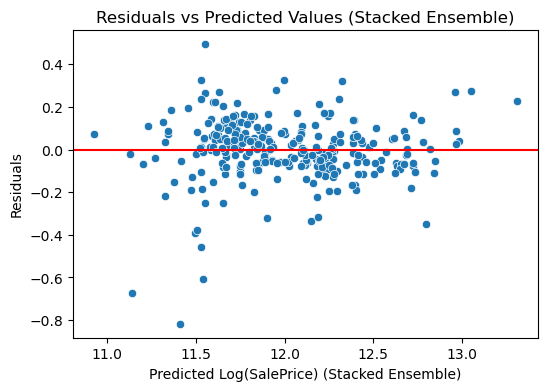

count    2.920000e+02
mean    -1.672939e-15
std      1.429452e-01
min     -8.173012e-01
25%     -6.522481e-02
50%      6.445801e-03
75%      7.352686e-02
max      4.962195e-01
Name: LogSalePrice, dtype: float64

In [13]:
ensemble_residuals = y_val - stack_pred

plt.figure(figsize=(6,4))
sns.scatterplot(x=stack_pred, y=ensemble_residuals)
plt.axhline(0, color="red")
plt.xlabel("Predicted Log(SalePrice) (Stacked Ensemble)")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted Values (Stacked Ensemble)")
plt.show()

ensemble_residuals.describe()

To combine the strengths of both Lasso and Random Forest, we implemented a stacked ensemble using linear regression as the meta-learner. By training the stacker on the validation predictions of both models, the ensemble learns the optimal weighting rather than relying on an arbitrary 50/50 average. This makes the final prediction more adaptive to the structure of the data.

The stacked model achieved a validation RMSE of **0.1427**, which is the best performance of any model tested so far. This improvement suggests that the ensemble successfully captures complementary information from both the linear and nonlinear base learners.

The learned weights further support this interpretation. The stacker assigned a weight of **0.6455** to the Lasso predictions and **0.4995** to the Random Forest predictions. Although Lasso receives greater influence, the non-zero weight on the Random Forest indicates that nonlinear patterns still contribute meaningful predictive signal.

The residual analysis shows that errors are tightly centered around zero with no visible pattern across predicted values, indicating that the model is not systematically over- or under-predicting. Although a few outliers remain, the overall distribution of residuals confirms that the ensemble captures the underlying structure without exhibiting noticeable bias.

Overall, the stacked ensemble enhances the analysis by:

- Learning an optimal blend of linear and nonlinear components  
- Improving predictive accuracy beyond any individual model  
- Offering interpretable coefficients that reveal how each model contributes to final predictions  

This approach provides the strongest and most balanced model in the workflow, demonstrating the value of combining diverse modeling strategies.


## Conclusion

Across this project, we explored a range of predictive modeling techniques to estimate log-transformed housing prices in the Ames dataset. Beginning with a strong baseline linear regression model (RMSE ≈ **0.1733**), we progressively introduced more advanced approaches to address multicollinearity, nonlinear relationships, and model interpretability. Each model contributed distinct strengths and provided insight into the structure of the data.

Lasso Regression achieved an RMSE of **0.1519**, outperforming the baseline by shrinking unimportant coefficients and stabilizing the model against correlated predictors. Random Forest Regression produced an RMSE of **0.1625**, capturing meaningful nonlinearities and interactions, though still falling short of Lasso’s performance. k-Nearest Neighbors served as an informative contrast but performed substantially worse (RMSE ≈ **0.2182**) due to the high-dimensional one-hot encoded feature space. 

The strongest model emerged from a stacked ensemble of Lasso and Random Forest, which achieved an RMSE of **0.1427**, the best performance observed. The meta-learner assigned slightly greater weight to Lasso while still incorporating nonlinear information from Random Forest, demonstrating that the two models capture complementary aspects of the data. This result highlights one of the central lessons of the project: no single method universally dominates, and combining models can produce meaningful gains in predictive accuracy.

Overall, this process underscored several key takeaways. First, thoughtful preprocessing and transformation of the target variable were essential in enabling stable and interpretable modeling. Second, regularization techniques proved highly effective in high-dimensional settings with multicollinearity. Third, tree-based methods added value by modeling nonlinear structure, even when not achieving the strongest standalone performance. Finally, ensemble methods provided the most robust solution by integrating the strengths of multiple approaches.

By comparing linear, nonlinear, instance-based, and ensemble models, this project illustrates the importance of methodological diversity and the benefits of model combination in predictive analytics. The stacked ensemble’s performance suggests that hybrid strategies often yield the most reliable predictions, especially in complex tabular datasets like Ames housing.
